# The `m = n` Machine Learning Anomaly

  * John Mount, [Win Vector LLC](https://www.win-vector/)
  * 3-April-2024

## Introduction

In our [last note](https://win-vector.com/2024/04/02/how-data-quantity-drives-model-quality/) we worked on how the training data size controls model quality in linear regression. At that time, to avoid some true horror, we deliberately avoided looking at small training sets where `m` (the number of training examples) was no more than `n` (the number of model parameters). In this note we will exhibit a model fitting anomaly that occurs when the number of training examples equals the number of model parameters. This anomaly is a variation variation of the ["double descent"](https://en.wikipedia.org/wiki/Double_descent) effect (where, for *an under-regularized model*, when the number of training examples is near the number of model parameters things *appear* worse than when there is less training data).

For a linear model we can explain what goes wrong using distributional arguments. We also show how [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) allows us to effectively work even in low-data situations. 


In [1]:
# import our modules and packages
import numpy as np
import pandas as pd
from overfit_fns import plot_error_curves


## Smaller training set sizes

Let's plot the effect of training set size on model loss (which we want to be low) for small training set sizes.


In [2]:
# read in previous experiment
plot_frame = pd.read_parquet('plot_frame_sizes.parquet')
plot_frame = (
    plot_frame
        .loc[np.isin(plot_frame['measurement'], ['RMSE train', 'RMSE ideal test']), :]
        .reset_index(drop=True, inplace=False)
)
alpha_min = np.min(plot_frame['alpha'])
n_variables = np.mean(plot_frame['n variables'])


In [3]:
plot_frame

,training rows,n variables,n parameters,alpha,measurement,value,L2 regularization,rmse_null,rmse_perfect
0,1,20,20,0.000001,RMSE train,1.228188e-07,1e-06,1.67332,1.0
1,1,20,20,0.000001,RMSE ideal test,1.578744e+00,1e-06,1.67332,1.0
2,2,20,20,0.000001,RMSE train,5.217586e-08,1e-06,1.67332,1.0
3,2,20,20,0.000001,RMSE ideal test,1.598601e+00,1e-06,1.67332,1.0
4,3,20,20,0.000001,RMSE train,6.427063e-08,1e-06,1.67332,1.0
...,...,...,...,...,...,...,...,...,...
31995,398,20,20,10000.000000,RMSE ideal test,1.627574e+00,10000.0,1.67332,1.0
31996,399,20,20,10000.000000,RMSE train,1.597567e+00,10000.0,1.67332,1.0
31997,399,20,20,10000.000000,RMSE ideal test,1.629946e+00,10000.0,1.67332,1.0
31998,400,20,20,10000.000000,RMSE train,1.635141e+00,10000.0,1.67332,1.0


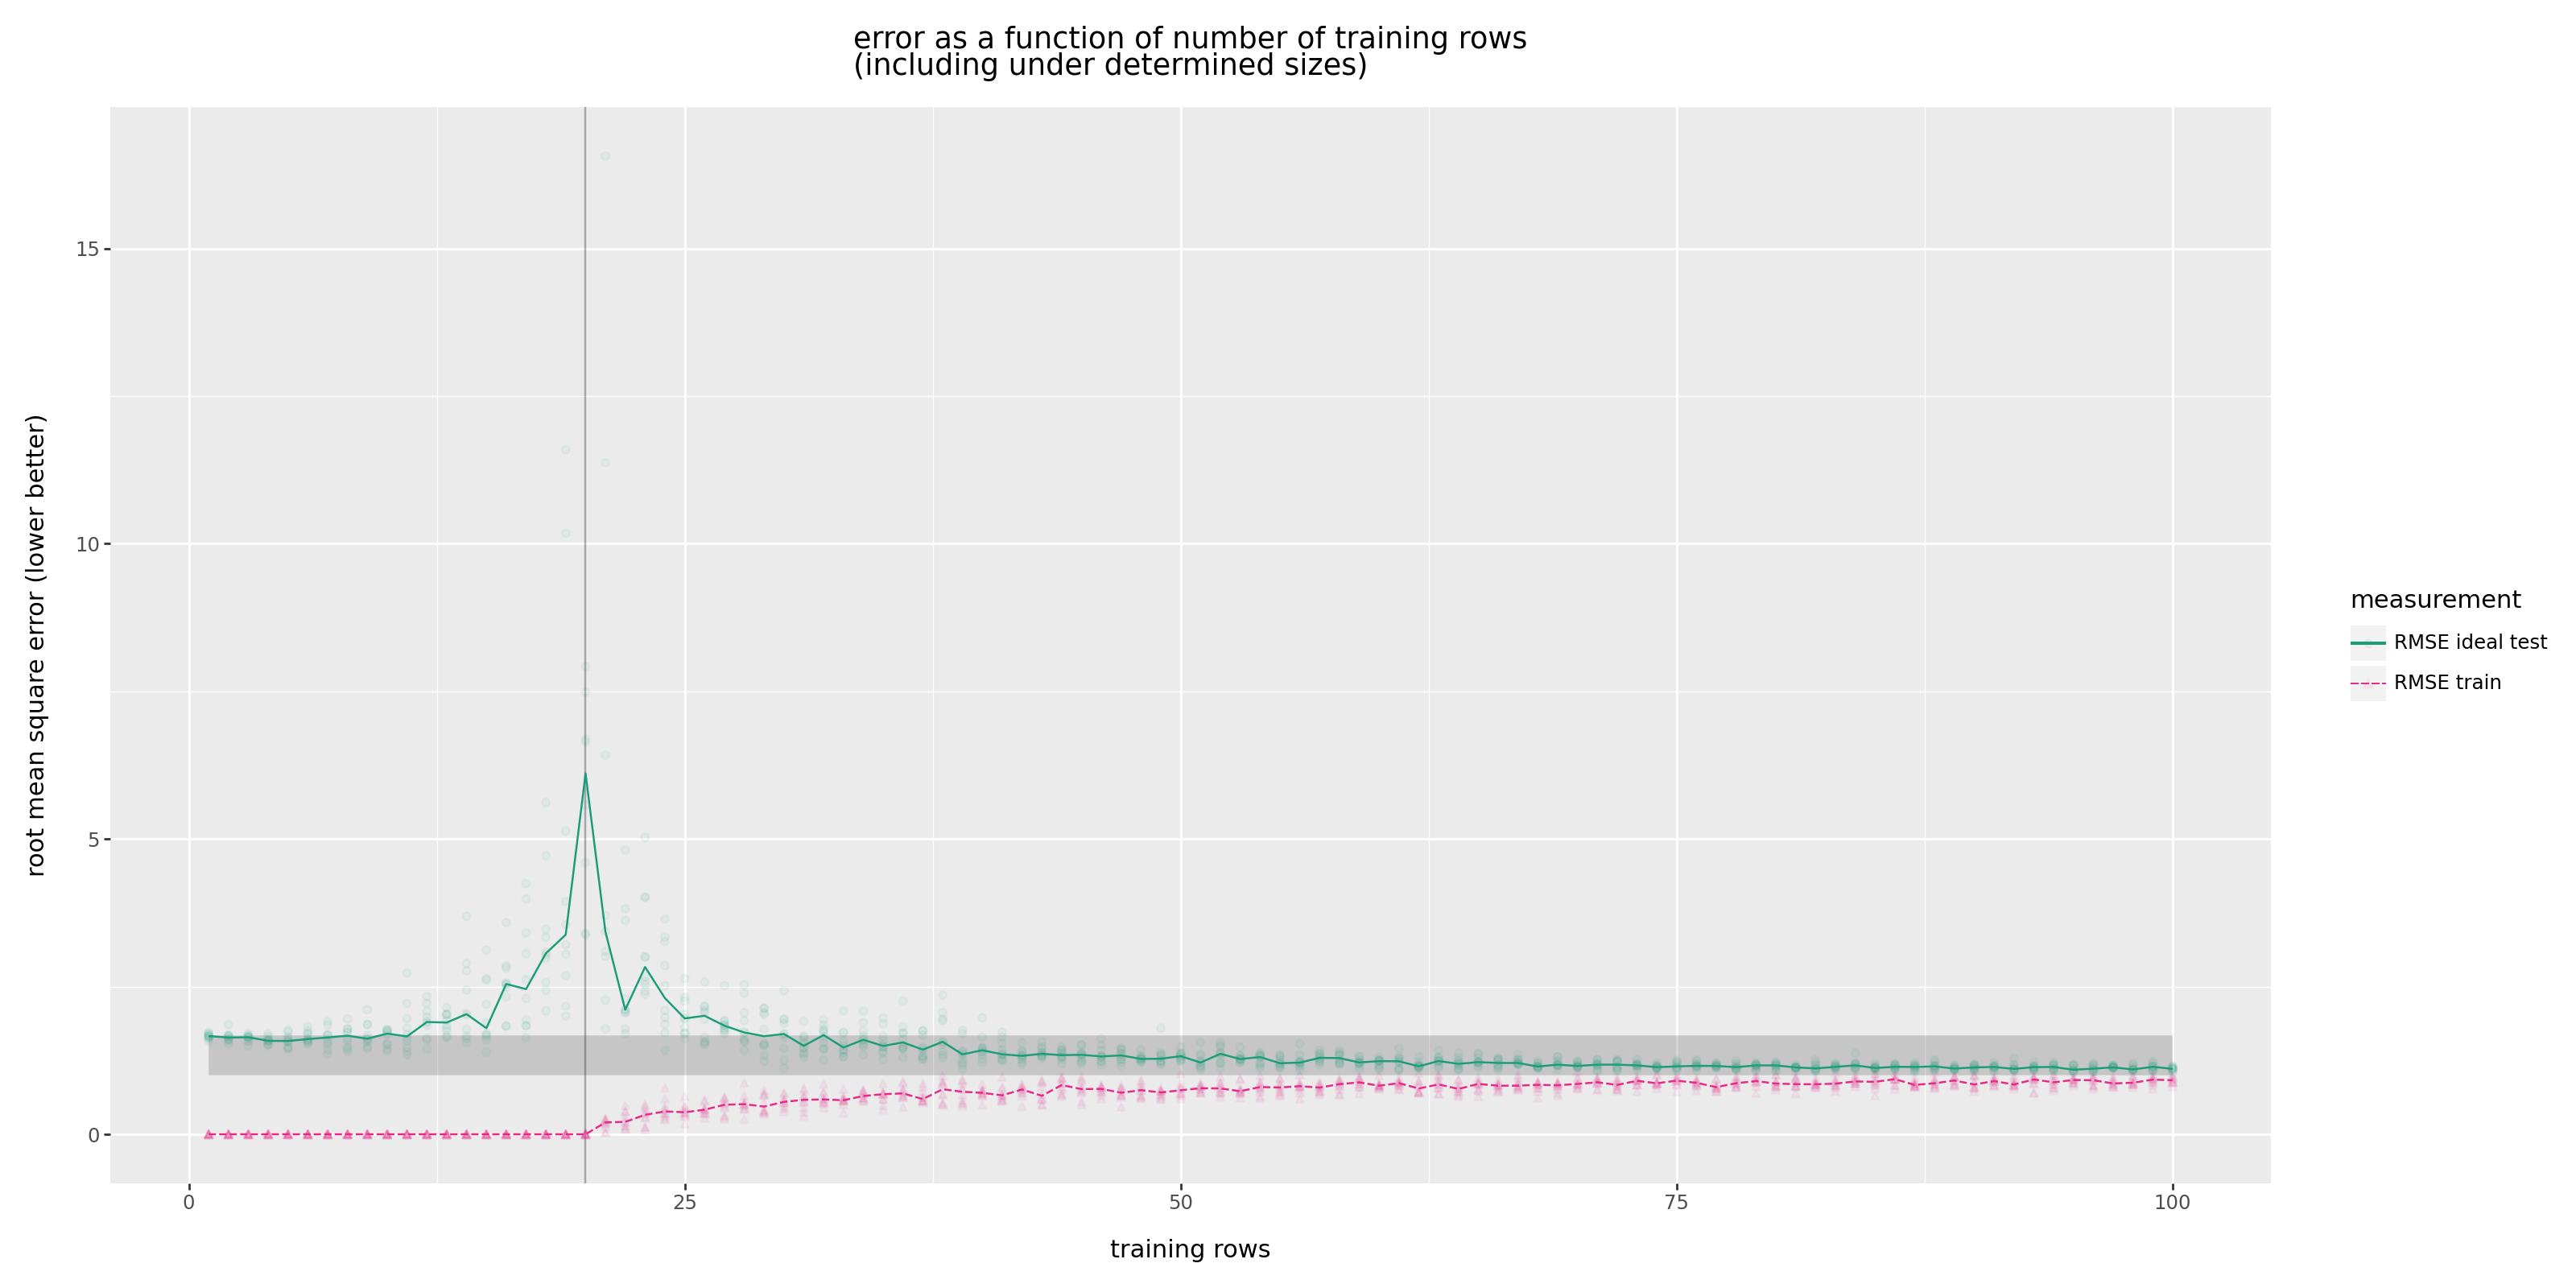

In [4]:
plot_error_curves(
    plot_frame.loc[
        (plot_frame['alpha'] == alpha_min)
        & (plot_frame['training rows'] <= 5 * n_variables)
        & (plot_frame['value'] <= 20)
        ,:],
    title="error as a function of number of training rows\n(including under determined sizes)",
    vline=n_variables
    )


Note: for legibility we have cropped this graph, many of the individual experiments (at the anomaly point) have extraordinary error (and the lines portrayed are medians of individual experiments per training row setting).

To read the graph of "loss as a function of training set size":

  * The x axis is the number of training rows. 
  * The y-axis is the loss or loss of fit models, so smaller is better. 
  * The grey region marks the vertical interval from best possible model performance (lower part of the band) through "null model" performance (behavior of a model that just predicts a single constant such as zero or the training mean). 
  * We have added a vertical line where the number of training examples equals the number of model variables.
  * The lower dashed curve is the behavior on training data. This show the fact that training performance tends to get worse as we add more training data (showing some of the irrelevance of evaluating on training data, or even the mistake of picking hyper-parameters using training data performance).
  * The upper solid cure is the behavior on held out or test data. This loss starts at near the null-model performance when we only have a single training row.  The solid curve, once we get past the vertical stroke representing the number of model parameters, has the crucial behavior of more training examples decreasing expected out of sample loss (i.e. yields a better model subject to diminishing returns). 

The anomaly we are interested in is the spike in out of sample error seen when the number of training examples matches the number of model parameters. This is also called "[double descent](https://en.wikipedia.org/wiki/Double_descent)", and was first popularized in neural net research (as this is the field that most often uses less training data than model parameters). Double descent is usually plotted on a graph where the number of model parameters is varying and training data set size is a constant. 


## The regularization fix

A great tool to work with less training data than parameters is "[regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics))". When we have too little training data (or constraints) we have what is called an "underdetermined system". This is a system with many solutions that we can not separate in terms of quality. The usual fix is: add an arbitrary additional constraint or criteria to help pick.

The criteria we will add is the famous Tikhonov regularization or Ridge regresssion: which is "pick model parameters with small 2-norm." How small a 2-norm is controlled with a parameter called "alpha" with "alpha=0" meaning "don't care about small/large", and larger alphas becoming more strict.

The earlier graphs were produced with regularization `alpha = 1e-6` to avoid the numeric issues that would be encountered with `alpha = 0` (standard regression). Let's try a few more, larger, alphas to see how regularization works.


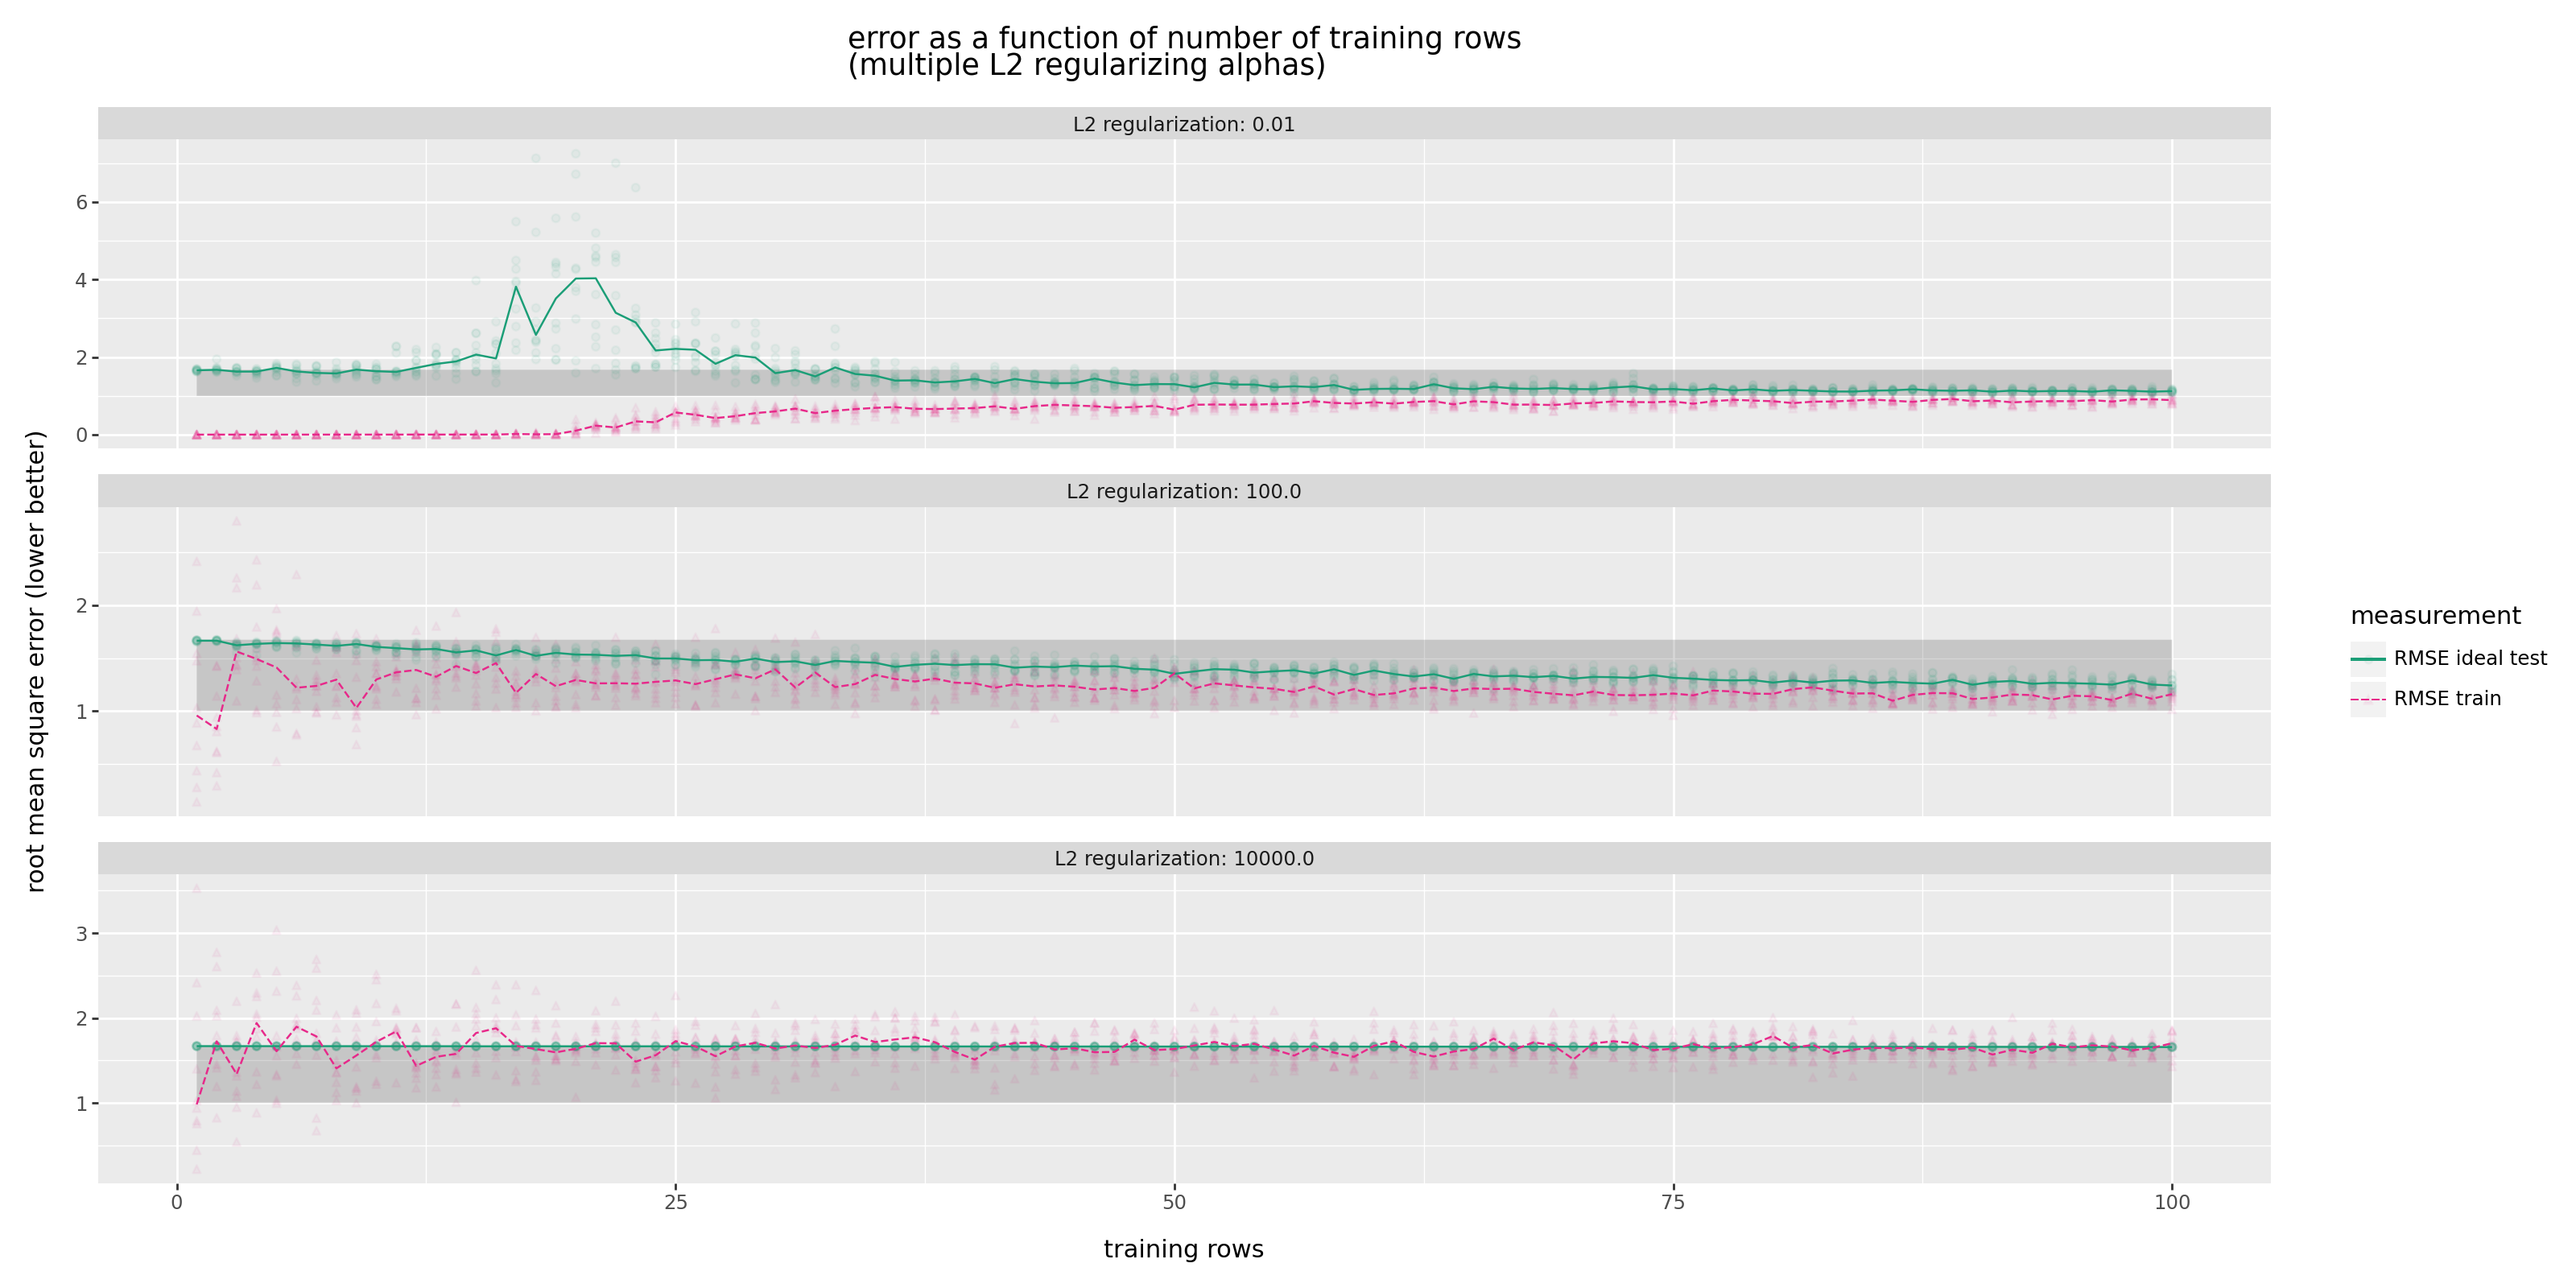

In [5]:
plot_error_curves(
    plot_frame.loc[
        (plot_frame['alpha'] != alpha_min)
        & (plot_frame['training rows'] <= 5 * n_variables)
        ,:],
    draw_points=True,
    draw_lines=True,
    title="error as a function of number of training rows\n(multiple L2 regularizing alphas)",
    )


Let's take a specific few observations from the graphs.

  * `alpha = 1-e2` behaves similarly to `alpha = 1e-6`. This emphasizes that `alpha` is a bit of a qualitative [hyper-parameter](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)). We don't really care about an exact "best value" for it. At this point we are still under-regularized- not much has been fixed.
  * `alpha = 100` is interesting. This is good regularization, it has eliminated the low-data spike, yet doesn't seem to "slow down learning" (make errors associated with large training set sizes) significantly worse. This is a great choice of for this problem, and larger than typical default values (emphasizing one must choose such hyper-parameters through cross validation methods).
  * `alpha = 10000` is bad (too large). Notice it causes large loss even at large training set sizes. This is over regularization, the model is ignoring the training data (which is why the observed errors on training are spread out so far).

Notice the (good) practice of picking an appropriate regularization hyper-parameter out-performs the (bad) practice of using less training dat to avoid the bad-performance spike. As with all hyper-parameters, we must pick the regularization using out-of-sample methods (such as test hold out or cross validation), else we would *wrongly* pick `alpha = 0`.


### Why not always regularize?

A question is: why do we not always regularize? Or, better yet, why isn't regularization always built in? 

My answer is: regularization should be used, but it causes some "technical debt".  The issue is: one needs to pick the degree of regularization (the hyper-parameter <code>alpha</code>) *and* where to regularize or shrink to (almost always hard-coded to <code>0</code>, but that isn't forced).

## The Cause of the Anomaly

For a linear model we can say why the anomaly occurs when the number of training examples equals the number of model parameters. The derivation is in the appendix of this note, but we will summarize here.

In fitting a model we are in one of three situations:

  * Less training data than examples. Usually we avoid this case entirely as bad practice. The observed error is not considered high as we don't expect good model quality in this region, and (we claim) we usually only witness highly regularized results in this situation. So there are low expectations and a bit of result censorship in this case.
  * Same amount of training data as examples. This is the critical case. One *can* fit or infer without regularization (though one probably should not!) and (for technical reasons we will explain) it is almost guaranteed the solution determined by the sample data will have unbounded out of sample error.
  * More training data than examples. This is the case where everything is expected to work, and in fact tends to work.

The upshot of the above: the same amount of training data as examples is the odd case. The other two cases are not as weird. For our weird case (when fitting a linear model where the number of training examples is equal to the number of model parameters) we can show the parameter estimates end up being the ratio of two similarly distributed random variables. This is a predictable crisis to learn: even in the most "garden variety" case of normal random variables, ratios of random variables are disasters to be avoided. We defer the details of this to an appendix.

## Conclusion

Low-data situations are mostly to be avoided, unless one is working with enormous and highly regularized models (such as deep neural nets and large language models). Fit in low-data situations depend both on the data and on the regularization scheme and regularization hyper-parameters, so models are no longer mere functions of the data. So, another sense of "more data is better" is: if you have enough data you do not have to deal with the issues we illustrated here.


## Appendices


### Appendix: What Causes the Spike at `m = n`

For a linear model with `m` training examples and `n`' model parameters we can describe the mechanism generating the "`m = n` spike".

Take `X` as an `m`-row by `n`-column matrix where each row is an example or instance and each column is a measurement or explanatory variable, and <code>&eta;</code> as an `m`-entry column vector where each entry is the numeric value we are trying to predict. We generate all entries of `X` and <code>&eta;</code> as *independent*, mean zero, variance 1, normally distributed random variables. One draw of `X` and <code>&eta;</code> is our training data. Another independent generation (with perhaps larger `m`) is our out-of-sample test or application data. As `X` and <code>&eta;</code> were generated independently, with no relation, this models the data from a regression problem of the form:

<code>y = X b + &eta;</code> with <code>b = 0</code> and <code>&eta;</code> the unexplainable variance or "error."

We call this our "no relation between <code>X</code> and <code>y</code>" case. <code>b = 0</code> *is* the model parameter value that minimizes error on new, unseen, data. We treat <code>y</code> as known to the estimation procedure. We treat the facts <code>y = &eta;</code> and <code>b = 0</code> as *unknown* to the estimation procedure, but important to our reasoning about the procedure.

The standard least squares regression inference or fitting process is to estimate an `n`-entry column vector estimate <code>b<sup>~</sup></code> such that <code>||y - X b<sup>~</sup>||</code> is minimal. The *hope* would be that <code>b<sup>~</sup></code> ends up near <code>b</code>. We would want at least the expectation <code>E[b<sup>~</sup>] = b = 0</code> (i.e. an unbiased estimate), and for the <code>b<sup>~</sup></code> estimation process to be low variance.


#### The `m = n = 1` case

In the `m = n = 1` case the standard least squares solution to the linear regression problem simplifies into a simple formula in terms of scalars:

<code>
b<sup>~</sup> = y / X = &eta; / X
</code>

For independent mean-zero normally distributed <code>&eta;</code> and <code>X</code> the ratio <code>b<sup>~</sup> = &eta; / X</code> is itself a [Cauchy distributed](https://en.wikipedia.org/wiki/Cauchy_distribution) random variable! We do *not* have the desired <code>E[b<sup>~</sup>] = 0</code>, the distribution is in fact so wild that <code>E[b<sup>~</sup>]</code> *does not even exist*! The process perfectly fits the training data, but completely fails to infer the parameters generating the data. With such bad parameter estimates: the model fails to match new data, and has huge out-of-sample error- producing the error spike.

This is the entire story, we just have to adapt it to larger examples.


#### The `m = n > 1` case

For this problem with probability 1: <code>X</code> is a full rank square matrix and invertible. The standard least squares linear model fitting method simplifies to the matrix equation:

<code>b<sup>~</sup> = X<sup>-1</sup> y = X<sup>-1</sup> &eta;</code>.

The standard trick in analyzing multi-linear systems (such as above) is to re-write such a system as a linear function of a subset of the variables (by picking fixed values for the other variables). To do this we use [Cramer's rule](https://en.wikipedia.org/wiki/Cramer%27s_rule) and [Laplace expansion](https://en.wikipedia.org/wiki/Laplace_expansion) to write <code>b<sup>~</sup><sub>i</sub></code> as:

<code>
b<sup>~</sup><sub>i</sub> = ( &Sigma;<sub>j=1...n</sub> (-1)<sup>i+j</sup> M<sub>i,j</sub> &eta;<sub>j</sub> ) / ( &Sigma;<sub>j=1...n</sub> (-1)<sup>i+j</sup> M<sub>i,j</sub> X<sub>i,j</sub> )
</code>

where <code>M<sub>i,j</sub></code> is the [determinant](https://en.wikipedia.org/wiki/Determinant) of the matrix <code>X</code> with the <code>i</code>th row and <code>j</code>th column deleted. By the [law of total expectation](https://en.wikipedia.org/wiki/Law_of_total_expectation) we have the [expected value](https://en.wikipedia.org/wiki/Expected_value) <code>E[b<sup>~</sup><sub>i</sub>]</code> is:

<code>
E[b<sup>~</sup><sub>i</sub>] = E[E[b<sup>~</sup><sub>i</sub> | M<sub>i,1</sub>, ..., M<sub>i,n</sub>]]
</code>

For a fixed <code>i</code>: the <code>M<sub>i,?</sub></code> don't depend on any of the random variables <code>X<sub>i,?</sub></code> and <code>&eta;<sub>?</sub></code>. This allows us to analyze the how our expected value varies as a *linear* function of the random variables <code>X<sub>i,?</sub></code> and <code>&eta;<sub>?</sub></code>. To do this assume fixed values for <code>M<sub>i,1</sub>, ..., M<sub>i,n</sub></code> and define:

  * <code>num<sub>i</sub> = &Sigma;<sub>j=1...n</sub> (-1)<sup>i+j</sup> M<sub>i,j</sub> &eta;<sub>j</sub></code>.
  * <code>den<sub>i</sub> = &Sigma;<sub>j=1...n</sub> (-1)<sup>i+j</sup> M<sub>i,j</sub> X<sub>i,j</sub></code>.

In these notations we see we have <code>num<sub>i</sub></code> and <code>den<sub>i</sub></code> are homogeneous linear combinations of the mean-zero independent [normally distributed random variables](https://en.wikipedia.org/wiki/Normal_distribution) <code>&eta;<sub>?</sub></code> and <code>X<sub>i,?</sub></code> respectively. Therefore <code>num<sub>i</sub></code> and <code>den<sub>i</sub></code> are themselves independent mean zero normally distributed random variables. Thus their ratio is proportional to a Cauchy distributed random variable, and the expected value does not exist.

As <code>E[b<sup>~</sup><sub>i</sub> | M<sub>i,1</sub>, ..., M<sub>i,n</sub>]</code> has no expected value or variance, then with probability 1 (probability in the the draw of the variables driving <code>M<sub>i,1</sub>, ..., M<sub>i,n</sub></code>), we have <code>E[b<sup>~</sup><sub>i</sub>]</code> itself can not be low variance. So <code>b<sup>~</sup><sub>i</sub></code> is not a reliable estimate of <code>b</code> in this case.

At this point we have derived the anomaly, it only remains to argue why this disaster isn't observed when `m` is not near `n`.


#### The `m >> n` case

For <code>m >> n</code> the standard solution to <code>y ~ X b</code> is <code>b<sup>~</sup> ~ (X<sup>&top;</sup> X)<sup>-1</sup> X<sup>&top;</sup> y</code>, or <code>b<sup>~</sup> ~ (X<sup>&top;</sup> X)<sup>-1</sup> X<sup>&top;</sup> &eta;</code>. Asymptotically if <code>m</code> is large, then <code>X<sup>&top;</sup> X</code> is (with high probability) very close to <code>m I</code> (<code>I</code> being the <code>n</code> by <code>n</code> identity matrix). This is enough to show that <code>(X<sup>&top;</sup> X)<sup>-1</sup></code> is usually close to <code>I / f(m)</code>, where <code>f(m)</code> is an (unspecified) function that approaches <code>f(m) ~ m - n</code> as <code>m</code> goes to infinity.

as <code>m</code> gets large (by [an application of the Marchenko Pastur Law](https://math.stackexchange.com/a/4224037) we expect <code>f(m)</code> goes 

Putting this all together, the expected value <code>E[b<sup>~</sup>]</code> is estimated by the standard least squares linear regression fitting procedure as:

<code>
<pre>
E[b<sup>~</sup>] = E[(X<sup>&top;</sup> X)<sup>-1</sup> X<sup>&top;</sup> y]
      = E[(X<sup>&top;</sup> X)<sup>-1</sup> X<sup>&top;</sup> &eta;]        # by our problem definition of y
      ~ E[(I / f(m)) X<sup>&top;</sup> &eta;]
      = E[I / f(m)] E[X<sup>&top;</sup>] E[&eta;]  # as all of these terms are independent!
      = E[I / f(m)] E[X<sup>&top;</sup>] 0     # &eta; is by definition, mean or expectation zero
      = 0
      = b                       # from our problem set up of b = 0
</pre>
</code>

The above is exactly what we want: <code>E[b<sup>~</sup>] ~ b</code>. The standard estimation procedure is reliable in this case.


#### The `m << n` case

For <code>m << n</code> the fitting problem is under-specified and many linear algebra solvers will fail or refuse to return an answer on this problem. The solution is no longer a matter of writing <code>b<sup>~</sup> ~ X<sup>-1</sup> y</code> (as <code>X</code> is not a simply invertible square matrix) or even of writing </code> <code>b<sup>~</sup> = (X<sup>&top;</sup> X)<sup>-1</sup> X<sup>&top;</sup> y</code> (as <code>X<sup>&top;</sup> X</code> remains an <code>n</code> by <code>n</code> matrix, but is rank deficient with rank no more than <code>m < n</code>).

The usual practice in to use one of the strongly related methods of singular value methods, [pseudo-inverses](https://en.wikipedia.org/wiki/Moore–Penrose_inverse), or [regularization methods](https://en.wikipedia.org/wiki/Regularization_(mathematics)). It turns out even though these look different, they all essentially imply regularization. A typical such solution is:

<pre>
<code>
b<sup>~</sup> ~ (X<sup>&top;</sup> X + &alpha; I)<sup>-1</sup> X<sup>&top;</sup> y
</code>
</pre>

where <code>&alpha; >= 0</code> is the regularization control.

In my opinion, even having results when `m << n` is evidence that the solving method actually used must have included a great amount of implicit or explicit regularization, and may be more sensitive to regularization in the regime (as there are insufficient data driven constraints). The regularization could be any or all of: drop-out, fuzzing/whitening, norm restriction (L1 and L2), pseudo-inverses, early stopping (fewer pivots), spectral methods (treating reciprocals of small singular values as zero), ensemble methods (integrating out over symmetries), variable selection, or other "harmless" details of underlying implementation methods.

### Glossary Terms

  * Cauchy–Binet formula [https://en.wikipedia.org/wiki/Cauchy–Binet_formula](https://en.wikipedia.org/wiki/Cauchy–Binet_formula)
  * Circular law [https://en.wikipedia.org/wiki/Circular_law](https://en.wikipedia.org/wiki/Circular_law)
  * Cramer's rule [https://en.wikipedia.org/wiki/Cramer%27s_rule](https://en.wikipedia.org/wiki/Cramer%27s_rule).
  * Determinant [https://en.wikipedia.org/wiki/Determinant](https://en.wikipedia.org/wiki/Determinant).
  * Double descent [https://en.wikipedia.org/wiki/Double_descent](https://en.wikipedia.org/wiki/Double_descent).
  * Expected value [https://en.wikipedia.org/wiki/Expected_value](https://en.wikipedia.org/wiki/Expected_value).
  * Gram matrix [https://en.wikipedia.org/wiki/Gram_matrix](https://en.wikipedia.org/wiki/Gram_matrix).
  * Independence [https://en.wikipedia.org/wiki/Independence_(probability_theory)](https://en.wikipedia.org/wiki/Independence_(probability_theory)).
  * James-Stein estimator [https://en.wikipedia.org/wiki/James–Stein_estimator](https://en.wikipedia.org/wiki/James–Stein_estimator).
  * Laplace expansion [https://en.wikipedia.org/wiki/Laplace_expansion](https://en.wikipedia.org/wiki/Laplace_expansion)
  * Law of total expectation [https://en.wikipedia.org/wiki/Law_of_total_expectation](https://en.wikipedia.org/wiki/Law_of_total_expectation).
  * Marchenko–Pastur distribution [https://en.wikipedia.org/wiki/Marchenko–Pastur_distribution](https://en.wikipedia.org/wiki/Marchenko–Pastur_distribution).
  * Moore–Penrose inverse [https://en.wikipedia.org/wiki/Moore–Penrose_inverse](https://en.wikipedia.org/wiki/Moore–Penrose_inverse).
  * Normal distribution [https://en.wikipedia.org/wiki/Normal_distribution](https://en.wikipedia.org/wiki/Normal_distribution).
  * "Regularization (mathematics)" [https://en.wikipedia.org/wiki/Regularization_(mathematics)](https://en.wikipedia.org/wiki/Regularization_(mathematics)).
  * Random variable [https://en.wikipedia.org/wiki/Random_variable](https://en.wikipedia.org/wiki/Random_variable).


Copyright &copy; 2018-2024 Win-Vector LLC.  All rights reserved. [http://www.win-vector.com](http://www.win-vector.com)
